In [1]:
# from masks, make an image with the background, boundary and inner pixels marked as 0, 1, 2
# for input to U-net
# also, as progressing, count up the proportion of each class in each image
# take an average proportion over all images for the weighted loss

import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt
from PIL import Image
from skimage import draw,io,segmentation
import time
import sys
import helper_functions as myutils
import seaborn as sns
import pandas as pd

TRAIN_PATH="/scratch_tmp/snk218/stage1_train"

In [2]:
img_ids=next(os.walk(TRAIN_PATH))[1]

In [111]:
import warnings

if(True):
    ave_class_weights=np.array([0.,0.,0.])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for i,image_id in enumerate(img_ids):

            if(i % 100 == 0):
                print(i)

            #print(image_id)

            # Load image
            img_file = os.path.join(TRAIN_PATH, image_id, "images", image_id+".png")
            image = Image.open(img_file).convert("RGB") # must return PIL image 

            # Load masks - masks are a series of binary images - one per nucleus
            mask_files = next(os.walk(os.path.join(TRAIN_PATH, image_id, "masks")))[2]

            labeled_masks=np.zeros((image.height,image.width), dtype='uint32')
            for i,mask_file in enumerate(mask_files):
                cur_mask = imread(os.path.join(TRAIN_PATH, image_id, "masks", mask_file)).astype('uint32')
                cur_mask=(cur_mask//255)*i
                labeled_masks+=cur_mask

            boundary_img=segmentation.find_boundaries(labeled_masks, mode='inner')

            # 0/1 background/nuclei
            labeled_masks=(labeled_masks>0).astype('uint8')
            
            # 0/1/2 background/nuclei/boundary
            labeled_masks = labeled_masks + (boundary_img.astype('uint8')*1) 
            
            # class weights for weighted loss
            class_weights=(image.height*image.width) / (3 * np.bincount(labeled_masks.flatten()))
            
            ave_class_weights+=class_weights

            save_file=os.path.join(TRAIN_PATH, image_id, image_id+'_boundaries.png')
            io.imsave(save_file, labeled_masks)
            
        ave_class_weights=ave_class_weights/len(img_ids)
        
print(ave_class_weights)

0
100
200
300
400
500
600
[ 0.39173999 10.32560528 38.03282406]


In [106]:
#ce_loss=nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float32))

array([64412,   832,   292])

In [101]:
ratios

array([ 0.33915005, 26.25641026, 74.81278539])

In [109]:
ave_class_weights

array([0.00050619, 0.03918867, 0.11166087])

In [91]:
id_="0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2"
#id_="ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb"
lmask = io.imread(TRAIN_PATH+'/'+id_+'/'+id_+'_boundaries.png')

/ext3/miniconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


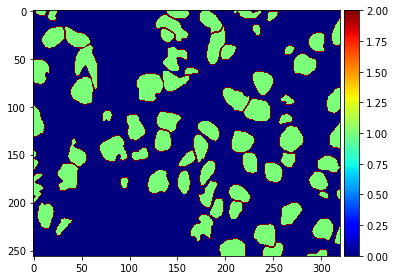

In [112]:
io.imshow(lmask, cmap='jet')

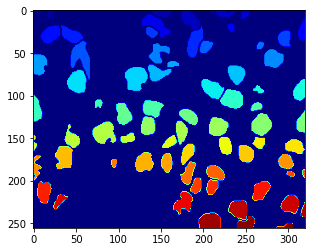

In [115]:
# To get separate masks:
from skimage import measure

regions=(lmask==1).astype('uint8')
labeled_regions=measure.label(regions)
plt.imshow(labeled_regions, cmap='jet')

In [116]:
obj_ids = np.unique(labeled_regions)
obj_ids = obj_ids[1:]
masks = labeled_regions == obj_ids[:, None, None]

In [120]:
print(masks.shape)

In [123]:
plt.imshow(masks[10]) # each mask separately

(72, 256, 320)

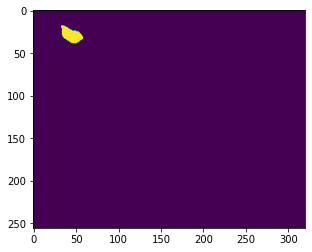